# **Analisis Sentimen Twitter**
### Caesar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Preparation

### 1.1. Import Library

In [ ]:
import csv
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
import ast
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords

# Libraries
import matplotlib.pyplot as plt

# Preliminaries
from torchtext.legacy.data import Field, TabularDataset, BucketIterator

# Models
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score, precision_score
import seaborn as sns


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### 1.2. Get Data and Data Cleaning

In [ ]:
# Get data ada di 'DataKodinganSkripsiCaesar.ipynb'

## 2. Preprocessing Data

### 2.1. Normalisasi Teks

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Data Skripsi/dataset_skripsi.csv")
# df = pd.read_csv("/content/drive/MyDrive/Data Skripsi/Tweet1.csv")
# df = df.drop('Unnamed: 0', axis=1)
# df = pd.read_csv("Tweet2.csv")
# df = pd.read_csv("yg dipakek.csv")
# df = pd.read_csv("Tweet3.csv")
# df = pd.read_csv("dataset_skripsi_500.csv")

# df = pd.read_csv("FinalSkripsi3 (Clean).csv") bukan ini
# df = pd.read_csv("dataset_skripsi tahap 8 (Revisi 1).csv") yg ini

In [ ]:
# df = df.drop('Unnamed: 0', axis=1)

In [ ]:
df.info

<bound method DataFrame.info of                                                   text  label_target
0                     @Tokocrypto dahlah, dikit" pajak             0
1    @Tokocrypto orang niat bikin project -90% past...             0
2    Alasan gw pilih platform @Tokocrypto buat trad...             1
3     @rakyact Otw install tokocrypto aja deh Ã°Å¸ËœÂ©             1
4    Aku sih dah percaya bgt sama Tokocrypto,, kere...             1
..                                                 ...           ...
495  @Tokocrypto TKO LOCK nggak ada ...harga tko ma...             0
496  Bisa bisanya kena sistem fraud tokocrypto Ã°Å¸...             0
497  @alvinindisa Padahal ini beli dari tokocrypto ...             0
498  Tokocrypto udah paling murah dan terpercaya pu...             1
499  Ada apa ya dengan tokocrypto . Mau ss tapi kag...             0

[500 rows x 2 columns]>

In [ ]:
df['label_target'].value_counts()

0    250
1    250
Name: label_target, dtype: int64

In [ ]:
df.text.to_list()

['@Tokocrypto dahlah, dikit" pajak',
 '@Tokocrypto orang niat bikin project -90% pasti dibuyback ini jualan doang, funda riset kontol',
 'Alasan gw pilih platform @Tokocrypto buat trading DODO karena Timeframe buat trading lengkap bgt sampe TF 1Menit yang cocok buat trading scalping juga adaÃ°Å¸Ëœï†\uf181.\nYuk pakai @Tokocrypto buat Trading DODO https://t.co/ZHSMwRZWiDÃ¢â‚¬Â¦\n#SiapLebihCuan \nhttps://t.co/Gq7c7l9DEP',
 '@rakyact Otw install tokocrypto aja deh Ã°Å¸ËœÂ©',
 'Aku sih dah percaya bgt sama Tokocrypto,, keren dan recommended,, apalagi #FiturTerbaruTokocrypto kita jadi\n#SiapLebihCuan dong pastinya',
 '@Tokocrypto Dan harga semakin hancur â€¦',
 'stlh denger space jadi makin paham deh sama trading. btw Tokocrypto lagi murah ges, mending beli deh cepet2 #SiapLebihCuan\n#FiturTerbaruTokocrypto',
 '@Tokocrypto  exchange besar dan nomor 1 di Indonesia\ndan juga sudah diawasi BAPPEBTI looo , jadi saya merasa aman trading $DODO @BreederDodo \nKode refferal bisa di copas\n\nhttps:/

In [ ]:
def clean_tweets(tweet):
    tweet = tweet.lower()

    # Menghapus mention, hastag, link 
    tweet = re.sub('(?:@\S*|#\S*|http(?=.*://)\S*)',' ',tweet)

    # Menghapus emoji
    tweet=re.sub("\\\\(?:x\w\w)","",tweet)
    
    # Mengubah non-ASCII dengan spasi
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    
    # Menghapus tanda baca
    tweet = re.sub('[^a-zA-Z]', ' ', tweet)
    
    # Menghapus tags
    tweet=re.sub("&lt;/?.*?&gt;","&lt;&gt;",tweet)
    
    # Menghapus angka dan karakter spesial
    tweet=re.sub("(\\d|\\W)+"," ",tweet)

    # Menghapus simbol
    tweet = re.sub(r'â', '', tweet)
    tweet = re.sub(r'€', '', tweet)
    tweet = re.sub(r'¦', '', tweet)

    tweet = tweet.strip()

    return tweet

In [ ]:
%%time
re_clean = df['text'].apply(lambda x: clean_tweets(x))
df['text'] = re_clean
df['text'] = df['text'].apply(lambda x: clean_tweets(x))

CPU times: user 33 ms, sys: 973 µs, total: 34 ms
Wall time: 41.8 ms


In [ ]:
df.text.to_list()

['dahlah dikit pajak',
 'orang niat bikin project pasti dibuyback ini jualan doang funda riset kontol',
 'alasan gw pilih platform buat trading dodo karena timeframe buat trading lengkap bgt sampe tf menit yang cocok buat trading scalping juga ada yuk pakai buat trading dodo',
 'otw install tokocrypto aja deh',
 'aku sih dah percaya bgt sama tokocrypto keren dan recommended apalagi kita jadi dong pastinya',
 'dan harga semakin hancur',
 'stlh denger space jadi makin paham deh sama trading btw tokocrypto lagi murah ges mending beli deh cepet',
 'exchange besar dan nomor di indonesia dan juga sudah diawasi bappebti looo jadi saya merasa aman trading dodo kode refferal bisa di copas',
 'beres smoga tokocrypto menjadi lebih baik',
 'jangan mau ketipu lagi sama exchange ini koin tko aja udah jadi ampas',
 'apa lagi ada kendalq deposit dari tadi gk masuk dan riwayat gk muncul sama sekali ada apa denganmu',
 'saya pilih sebagi platform trading token dodo dikarenakan tampilan dan kemudahan ui 

### 2.2. Menghapus Karakter Berlebihan Pada Akhir Kata

In [ ]:
def remove_same_character_last_words(textt):
    textt = textt.strip()
    textt = textt.lower()
    reverse_word = "".join(list(reversed(textt)))

    first_char = reverse_word[:1]

    n_iteration = 2

    same_char = 0

    while(first_char==reverse_word[(n_iteration-1):n_iteration]):
        same_char += 1
        n_iteration += 1

    new_text = reverse_word[same_char:]

    new_text = "".join(list(reversed(new_text)))

    return new_text

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
%%time
last_word_list = []
for text in df['text']:
    text = text.strip()
    temp_list = word_tokenize(text)
    temp_clean = [remove_same_character_last_words(word) for word in temp_list]
    last_word_list.append(" ".join(temp_clean))

df['text'] = last_word_list

CPU times: user 151 ms, sys: 0 ns, total: 151 ms
Wall time: 162 ms


In [ ]:
df.text.to_list()

['dahlah dikit pajak',
 'orang niat bikin project pasti dibuyback ini jualan doang funda riset kontol',
 'alasan gw pilih platform buat trading dodo karena timeframe buat trading lengkap bgt sampe tf menit yang cocok buat trading scalping juga ada yuk pakai buat trading dodo',
 'otw instal tokocrypto aja deh',
 'aku sih dah percaya bgt sama tokocrypto keren dan recommended apalagi kita jadi dong pastinya',
 'dan harga semakin hancur',
 'stlh denger space jadi makin paham deh sama trading btw tokocrypto lagi murah ges mending beli deh cepet',
 'exchange besar dan nomor di indonesia dan juga sudah diawasi bappebti lo jadi saya merasa aman trading dodo kode refferal bisa di copas',
 'beres smoga tokocrypto menjadi lebih baik',
 'jangan mau ketipu lagi sama exchange ini koin tko aja udah jadi ampas',
 'apa lagi ada kendalq deposit dari tadi gk masuk dan riwayat gk muncul sama sekali ada apa denganmu',
 'saya pilih sebagi platform trading token dodo dikarenakan tampilan dan kemudahan ui ux 

### 2.3. Stemming

In [ ]:
%%time
factory = StemmerFactory()
stemmer = factory.create_stemmer()

list_stem = [stemmer.stem(str(txt)) for txt in df['text']]

CPU times: user 1min 35s, sys: 306 ms, total: 1min 36s
Wall time: 1min 50s


In [ ]:
df['text'] = list_stem

In [ ]:
df.text.to_list()

['dah dikit pajak',
 'orang niat bikin project pasti dibuyback ini jual doang funda riset kontol',
 'alas gw pilih platform buat trading dodo karena timeframe buat trading lengkap bgt sampe tf menit yang cocok buat trading scalping juga ada yuk pakai buat trading dodo',
 'otw instal tokocrypto aja deh',
 'aku sih dah percaya bgt sama tokocrypto keren dan recommended apalagi kita jadi dong pasti',
 'dan harga makin hancur',
 'stlh denger space jadi makin paham deh sama trading btw tokocrypto lagi murah ges mending beli deh cepet',
 'exchange besar dan nomor di indonesia dan juga sudah awas bappebti lo jadi saya rasa aman trading dodo kode refferal bisa di copas',
 'beres smoga tokocrypto jadi lebih baik',
 'jangan mau tipu lagi sama exchange ini koin tko aja udah jadi ampas',
 'apa lagi ada kendalq deposit dari tadi gk masuk dan riwayat gk muncul sama sekali ada apa dengan',
 'saya pilih bagi platform trading token dodo karena tampil dan mudah ui ux nya dalam jual beli aset kripto selai

### 2.4. Mengubah Slang Words

#### 2.4.1. Dua Dataset Slang di load dan dijadikan dictionary

Dataset 1

In [ ]:
slang_word = pd.read_csv("/content/drive/MyDrive/Data Skripsi/colloquial-indonesian-lexicon.csv")
slang_word

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0
...,...,...,...,...,...,...,...
15001,gataunya,enggak taunya,0,Ini kaya nenek2 ya beb gataunya agnezz @yugime...,akronim,0,0
15002,gtau,enggak tau,0,Stidaknya mrka may berkarya Dan berusaha yg tr...,akronim,abreviasi,0
15003,gatau,enggak tau,0,Ih gatau malu,akronim,0,0
15004,fans2,fan-fan,0,Jkt48 adalah tempat di mana sesama fans saling...,reduplikasi,naturalisasi,0


In [ ]:
dict_data_1 = dict(zip(slang_word.slang, slang_word.formal))
len(dict_data_1)

4331

Dataset 2

In [ ]:
# Read Data
file_2  = open("/content/drive/MyDrive/Data Skripsi/combined_slang_words.txt", "r")
content2 = file_2.read()

# Transform into dictionary
slang_word_2 = ast.literal_eval(content2)
file_2.close()

dict_data_2 = slang_word_2

#### 2.3.2. Menggabungkan 2 Data Slang

In [ ]:
print('Banyak baris pada dictionary 1: ', len(dict_data_1))
print('Banyak baris pada dictionary 2: ',len(dict_data_2))
print('-----------------------------------------')

dict3 = {**dict_data_1 , **dict_data_2}
print('Hasil Akhir panjang data slang: ',len(dict3))

Banyak baris pada dictionary 1:  4331
Banyak baris pada dictionary 2:  1018
-----------------------------------------
Hasil Akhir panjang data slang:  5042


In [ ]:
# Coba
# dict3 = dict_data_2

#### 2.3.3. Mengubah Teks yang mengandung Slang pada Dictionary

In [ ]:
word_changed = []
slang_changed = []
def slang_check(string):
    string = str(string)
    list_word =[]
    for word_text in string.split(' '):
        slang = dict3.get(word_text)
        if slang == None:
            list_word.append(word_text)
        else:
            list_word.append(slang)
            word_changed.append(word_text)
            slang_changed.append(slang)
    new_string = " ".join(list_word)
    return new_string

In [ ]:
%%time
list_text_after_slang = list(map(lambda x: slang_check(x), df['text']))
df['text'] = list_text_after_slang
print('Jumlah Kata Terubah',len(word_changed))

Jumlah Kata Terubah 823
CPU times: user 6.01 ms, sys: 7 µs, total: 6.02 ms
Wall time: 6.43 ms


In [ ]:
len(word_changed)

823

In [ ]:
# df.text.to_list()

### 2.4. Menghapus Stopwords

In [ ]:
# import nltk
# nltk.download('stopwords')

In [ ]:
# stopw = stopwords.words('indonesian')
# len(stopw)

In [ ]:
# # Menghapus kata negasi pada stopword
# negasi = ["bukan", "bukanlah", "enggak", "kurang", "tidak","tidaklah", "anti"]
# for word in stopw:
#     if word in negasi:
#         stopw.remove(word)
# len(stopw)

In [ ]:
# def remove_stop(text):
#     text_tokens = word_tokenize(text)
#     tokens_without_sw = [word for word in text_tokens if not word in stopw]
#     filtered_sentence = (" ").join(tokens_without_sw)
#     return filtered_sentence

In [ ]:
# df['text'] = [remove_stop(x) for x in df['text']]

In [ ]:
# df.text.to_list()

### 2.5. Data Splitting

In [ ]:
df['label_target'].isnull().values.any()

False

In [ ]:
df = df.dropna()

In [ ]:
df['label_target'].value_counts()

0    250
1    250
Name: label_target, dtype: int64

In [ ]:
df_train, df_test = train_test_split(df, stratify=df['label_target'], test_size = 0.2, random_state=42)
print('Banyaknya baris train: ', len(df_train))
print('Banyaknya baris test: ', len(df_test))

print('------------------------------------')
print('Pembagian label pada data train')
print( df_train['label_target'].value_counts())

Banyaknya baris train:  400
Banyaknya baris test:  100
------------------------------------
Pembagian label pada data train
1    200
0    200
Name: label_target, dtype: int64


In [ ]:
df_train, df_valid = train_test_split(df_train, stratify=df_train['label_target'], test_size = 0.1, random_state=42)
print('Banyaknya baris train: ', len(df_train))
print('Banyaknya baris valid: ', len(df_valid))

print('------------------------------------')
print('Pembagian label pada data train')
print( df_train['label_target'].value_counts())

Banyaknya baris train:  360
Banyaknya baris valid:  40
------------------------------------
Pembagian label pada data train
0    180
1    180
Name: label_target, dtype: int64


In [ ]:
#Save Dataset

df_train.to_csv(r'C:\Users\DaMxNeD\Downloads\train_non_slang.csv', index=False)
df_test.to_csv(r'C:\Users\DaMxNeD\Downloads\test_non_slang.csv', index=False)
df_valid.to_csv(r'C:\Users\DaMxNeD\Downloads\valid_non_slang.csv', index=False)

In [ ]:
#Save Dataset

df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)
df_valid.to_csv('valid.csv', index=False)

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
#df_train['text'].to_list()

In [ ]:
df_train

,text,label_target
0,bicara tko dari usd sampai scam begitu urus tk...,0
1,pakai banyak banget untung harga murah lagi ba...,1
2,tko kontol tiap beli tko minus melulu ponzi an...,0
3,wah jadi sekarang gampang banget deh tokocrypt...,1
4,sudah sampai kak cuman di tokocrypto ku yang m...,0
...,...,...
355,lebih baik guna tokocrypto karena lebih murah,1
356,turut saya pribadi sangat tidak rekomendasi me...,0
357,exchange besar dan nomor di indonesia dan juga...,1
358,kalau buat menerima prize win iya jelas lebih ...,1


## 3. Data Modelling

### 3.1 Import data ke pytorch

In [ ]:
folder_data = 'Data'
folder_model = 'Model'

In [ ]:
!python -m spacy download xx_sent_ud_sm

2023-01-04 16:32:38.050393: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 9.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('xx_sent_ud_sm')


In [ ]:
folder_data = 'Data'
folder_model = 'Model'

# Labelling pada Pytorch
field_label = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
field_text = Field(tokenize='spacy',tokenizer_language='xx_sent_ud_sm', lower=True, include_lengths=True, batch_first=True)
fields = [ ('text', field_text), ('label_target', field_label)]

# Mengambill data
#tab_train, tab_valid, tab_test = TabularDataset.splits(path=folder_data, train='train_non_slang.csv', validation='valid_non_slang.csv', test='test_non_slang.csv',
#                                           format='CSV', fields=fields, skip_header=True)
tab_train, tab_valid, tab_test = TabularDataset.splits(path = './', train='train.csv', validation='valid.csv', test='test.csv', format='CSV', fields=fields, skip_header=True)

train_data = BucketIterator(tab_train, batch_size=32, sort_key=lambda a: len(a.text),
                            device=device, sort=True, sort_within_batch=True)
valid_data = BucketIterator(tab_valid, batch_size=32, sort_key=lambda a: len(a.text),
                            device=device, sort=True, sort_within_batch=True)
test_data = BucketIterator(tab_test, batch_size=32, sort_key=lambda a: len(a.text),
                            device=device, sort=True, sort_within_batch=True)

#Membuat Vocab
field_text.build_vocab(tab_train, min_freq=3)

In [ ]:
print('Banyaknya row data train: ', len(tab_train))

Banyaknya row data train:  360


In [ ]:
print(vars(tab_train.examples[0]))

{'text': ['bicara', 'tko', 'dari', 'usd', 'sampai', 'scam', 'begitu', 'urus', 'tko', 'mu', 'dulu', 'baru', 'urus', 'coin', 'lain'], 'label_target': '0'}


In [ ]:
print(vars(tab_test.examples[44]))

{'text': ['etf', 'linkup', 'bagaimana', 'enggak', 'ada', 'jelas'], 'label_target': '0'}


In [ ]:
label_size = {'Negative': 0, 'Positive':0}
for i in range(len(tab_train)):
    label_temp = vars(tab_train[i])['label_target']
    if label_temp == '1':
        label_size['Positive'] += 1
    else:
        label_size['Negative'] += 1
    
print(label_size)

{'Negative': 180, 'Positive': 180}


In [ ]:
max_len_text = 0
for i in range(len(tab_train)):
    text_temp = vars(tab_train[i])['text']
    if len(text_temp) > max_len_text:
        max_len_text = len(text_temp)

print('Maksimal panjang teks', max_len_text)

Maksimal panjang teks 47


In [ ]:
print(field_text.vocab.freqs.most_common(20))

[('tokocrypto', 133), ('dan', 118), ('trading', 117), ('yang', 103), ('di', 102), ('tko', 96), ('dodo', 76), ('untuk', 74), ('ini', 71), ('enggak', 67), ('saya', 65), ('mudah', 59), ('sudah', 57), ('banget', 54), ('buat', 54), ('karena', 50), ('ada', 49), ('jadi', 44), ('juga', 43), ('lagi', 42)]


In [ ]:
len(field_text.vocab)

348

In [ ]:
field_text.vocab.stoi['trading']

4

In [ ]:
field_text.vocab.itos[:10]

['<unk>',
 '<pad>',
 'tokocrypto',
 'dan',
 'trading',
 'yang',
 'di',
 'tko',
 'dodo',
 'untuk']

In [ ]:
field_text.vocab.itos[18]

'ada'

In [ ]:
print(vars(tab_train.examples[0]))

{'text': ['bicara', 'tko', 'dari', 'usd', 'sampai', 'scam', 'begitu', 'urus', 'tko', 'mu', 'dulu', 'baru', 'urus', 'coin', 'lain'], 'label_target': '0'}


In [ ]:
for ((text, len_text), label), _ in train_data:
    print('ROW----------------------------------------------------')
    print(text.shape)
    print("label", label)
    print("text", text, 'Lenn', len_text)
    print("___", _)

ROW----------------------------------------------------
torch.Size([32, 5])
label tensor([1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
text tensor([[216,   0,  20, 347, 341],
        [130,  15,  86,  42,   2],
        [ 37,   7, 139,  92,   0],
        [ 28,  93,  42,   2,  30],
        [122,  10,  43, 105,  66],
        [122,   7,  43, 105,  66],
        [ 10, 190,  87,  16,  91],
        [ 78,   7, 139, 322, 103],
        [  7,  31, 122, 120, 145],
        [292, 270,   0,  37,  43],
        [161,  60,  15,   0,   1],
        [  7, 284,   5, 127,   1],
        [ 37,   7, 139,  92,   1],
        [ 37,   7,  31,   0,   1],
        [ 37,  82,   3,  43,   1],
        [  0,   0, 188,  66,   1],
        [ 28, 291,  28, 198,   1],
        [ 52,  71,   6, 308,   1],
        [  0, 335,  42,   2,   1],
        [  7,  31,   0,   1,   1],
        [ 37,  82,   0,   1,   1],
        [  0,   0,   7,   1,   1]

### 3.2 Membuat Model LSTM

In [ ]:
torch.__version__

'1.9.0+cu102'

In [ ]:
class LSTM(nn.Module):
    def __init__(self, hidden_layer=256, lstm_layer=3, embedding_layer=100, p=0.5):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(field_text.vocab), embedding_layer)
        self.dimension = hidden_layer
        self.lstm = nn.LSTM(input_size=embedding_layer,
                            hidden_size=hidden_layer,
                            num_layers=lstm_layer,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=p)

        self.fc = nn.Linear(2*hidden_layer, 1)

    def forward(self, text, len_text):

        #Word Embedding
        text_embedding = self.embedding(text)

        #Masuk ke layer LSTM
        input_packed = pack_padded_sequence(text_embedding, len_text.to('cpu'), batch_first=True, enforce_sorted=False)
        ouput_packed, _ = self.lstm(input_packed)
        output_lstm_all, _ = pad_packed_sequence(ouput_packed, batch_first=True)

        output_lstm_forward = output_lstm_all[range(len(output_lstm_all)), len_text - 1, : self.dimension]
        output_lstm_reverse = output_lstm_all[:, 0, self.dimension:]
        output_concat = torch.cat((output_lstm_forward, output_lstm_reverse), 1)
        
        output_dropped = self.drop(output_concat)

        #With drop
        text_fc = self.fc(output_dropped)

        text_squeeze = torch.squeeze(text_fc, 1)
        final_output = torch.sigmoid(text_squeeze) 

        return final_output

In [ ]:
def save_history_loss(folder_save, list_train_loss, list_valid_loss, global_steps_list):

    if folder_save == None:
        return
    
    history_loss = {'list_train_loss': list_train_loss,
                  'list_valid_loss': list_valid_loss,
                  'global_steps_list': global_steps_list}
    
    torch.save(history_loss, folder_save)


def load_history_loss(folder_load):

    if folder_load == None:
        return
    
    history_loss = torch.load(folder_load, map_location=device)
    
    return history_loss['list_train_loss'], history_loss['list_valid_loss'], history_loss['global_steps_list']

### 3.3 Membuat Fungsi Training

In [ ]:
# Inisialisasi Training

hidden_layer = 256
lstm_layer = 3
embedding_layer = 100
learning_rate = 0.001
epoch = 16
dropout = 0.6

torch.manual_seed(42)
model = LSTM(hidden_layer=hidden_layer, lstm_layer=lstm_layer, embedding_layer=embedding_layer, p=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

In [ ]:
def model_run_train(model_train,
          optimizer_train,
          criterion = nn.BCELoss(),
          scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5),
          train_dataloader = train_data,
          valid_dataloader = valid_data,
          num_epochs = 16,
          mode_gridsearch = False,
          eval_half = len(train_data) // 2,
          folder_path = folder_model ):
    
    # Inisialisasi
    list_train_loss = []
    list_valid_loss = []
    global_steps_list = []

    train_loss_running = 0.0
    valid_loss_running = 0.0
    global_steps = 0
    total_global_steps = num_epochs*len(train_dataloader)

    lr = scheduler.get_last_lr()
    # lr = optimizer.param_groups[0]['lr']

    # Pelatihan pada looping
    model_train.train()
    for epoch in range(num_epochs):
        for ((text, len_text), labels), _ in train_dataloader:
       
            text = text.to(device)
            len_text = len_text.to(device)
            labels = labels.to(device)   
            
            # Pelatihan model dengan data tersedia
            output_model = model_train(text, len_text)
            loss = criterion(output_model, labels)

            optimizer_train.zero_grad()
            loss.backward()
            optimizer_train.step()

            # Update nilai Loss
            train_loss_running += loss.item()
            global_steps += 1

            # Tahap evaluasi terhadap valid data
            if global_steps % eval_half == 0:
                model_train.eval()
                with torch.no_grad():                    
                  # Valid data
                  for ((text, len_text), labels ), _ in valid_dataloader:
                      labels = labels.to(device)
                      text = text.to(device)
                      len_text = len_text.to(device)
                      
                      output_model = model_train(text, len_text)
                      loss = criterion(output_model, labels)

                      valid_loss_running += loss.item()

                # Evaluasi
                avg_train_loss = train_loss_running / eval_half
                avg_valid_loss = valid_loss_running / len(valid_dataloader)
                
                list_train_loss.append(avg_train_loss)
                list_valid_loss.append(avg_valid_loss)
                global_steps_list.append(global_steps)

                # Mengubah ke nilai awal
                train_loss_running = 0.0                
                valid_loss_running = 0.0
                model_train.train()
                scheduler.step()

                # Print untuk Iterasi
                if mode_gridsearch == True:
                    continue
                else:
                    print(f'Epoch [{epoch+1}/{num_epochs}] | Global Steps [{global_steps}/{total_global_steps}] | Train Loss: {avg_train_loss:.4f} | Valid Loss: {avg_valid_loss:.4f} | Learning Rate: {scheduler.get_last_lr()[0]:.4f} ')
                
    save_history_loss('metrics.pt', list_train_loss, list_valid_loss, global_steps_list)

    # print('Last Learning Rate :' + str(scheduler.get_last_lr()[0]))
    # print(optimizer.param_groups[0]['lr'])

    return list_valid_loss[-1], list_train_loss[-1]

In [ ]:
hidden_layer = 128
lstm_layer = 3
embedding_layer = 200
learning_rate = 0.01
epoch = 16
dropout = 0.7
step_size = 5
gamma = 1

torch.manual_seed(42)
model = LSTM(hidden_layer=hidden_layer, lstm_layer=lstm_layer, embedding_layer=embedding_layer, p=dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma) 

model_run_train(model_train=model, optimizer_train=optimizer, num_epochs=epoch, scheduler=scheduler)

Epoch [1/16] | Global Steps [6/192] | Train Loss: 0.6574 | Valid Loss: 0.4775 | Learning Rate: 0.0100 
Epoch [1/16] | Global Steps [12/192] | Train Loss: 0.3873 | Valid Loss: 0.3098 | Learning Rate: 0.0100 
Epoch [2/16] | Global Steps [18/192] | Train Loss: 0.2415 | Valid Loss: 0.1944 | Learning Rate: 0.0100 
Epoch [2/16] | Global Steps [24/192] | Train Loss: 0.1145 | Valid Loss: 0.1825 | Learning Rate: 0.0100 
Epoch [3/16] | Global Steps [30/192] | Train Loss: 0.1265 | Valid Loss: 0.0825 | Learning Rate: 0.0100 
Epoch [3/16] | Global Steps [36/192] | Train Loss: 0.0907 | Valid Loss: 0.1025 | Learning Rate: 0.0100 
Epoch [4/16] | Global Steps [42/192] | Train Loss: 0.0840 | Valid Loss: 0.2249 | Learning Rate: 0.0100 
Epoch [4/16] | Global Steps [48/192] | Train Loss: 0.0241 | Valid Loss: 0.0325 | Learning Rate: 0.0100 
Epoch [5/16] | Global Steps [54/192] | Train Loss: 0.0266 | Valid Loss: 0.0162 | Learning Rate: 0.0100 
Epoch [5/16] | Global Steps [60/192] | Train Loss: 0.0041 | Valid

(0.0004689810812124051, 0.00010047289712626177)

### 3.4 Visualisasi pada model loss

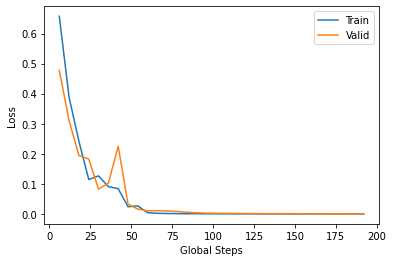

In [ ]:
list_train_loss, list_valid_loss, global_steps_list = load_history_loss('metrics.pt')
plt.plot(global_steps_list, list_train_loss, label='Train')
plt.plot(global_steps_list, list_valid_loss, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

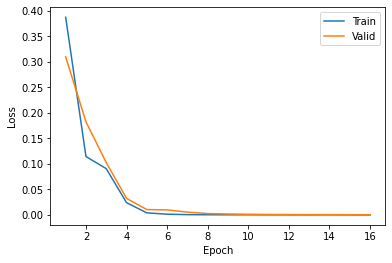

In [ ]:
temp_train = []
temp_valid = []
for i in range(len(list_train_loss)):
    if (i+1) % 2 != 0:
        continue
    temp_train.append(list_train_loss[i])
    temp_valid.append(list_valid_loss[i])

ep_list = range(1, epoch+1)

plt.plot(ep_list, temp_train, label='Train')
plt.plot(ep_list, temp_valid, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 

### 3.5 Evaluasi Data Testing

In [ ]:
# Evaluation Function

def model_evaluate(model, test_loader, mode_gridsearch = False):
    threshold=0.5
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for ((text, len_text), labels), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            len_text = len_text.to(device)
            
            output_model = model(text, len_text)

            # 0.5 keatas menjadikan label 1
            output_model = (output_model > threshold).int()
            
            y_pred.extend(output_model.tolist())
            y_true.extend(labels.tolist())

    if mode_gridsearch == True :
        return f1_score(y_true, y_pred), precision_score(y_true, y_pred, zero_division=0), recall_score(y_true, y_pred)
    else:
        print('Classification Report:')
        #print(accuracy_score(y_true, y_pred))
        print(f1_score(y_true, y_pred))
        #print(precision_score(y_true,y_pred))
        #print(recall_score(y_true,y_pred))
        print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
        
        ax= plt.subplot()
        cm = confusion_matrix(y_true, y_pred, labels=[1,0])
        sns.heatmap(cm, annot=True, ax = ax, fmt="d")

        ax.xaxis.set_ticklabels(['Positive', 'Negative'])
        ax.yaxis.set_ticklabels(['Positive', 'Negative'])

        ax.set_title('Confusion Matrix')

        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')

        #for i in range(len(y_pred)):
        #    print(f'{y_pred[i]} | {y_true[i]}')
        #print(y_pred)
        #print('------------------------')
        #print(y_true)
   
        return

Classification Report:
0.9484536082474226
              precision    recall  f1-score   support

           1     0.9787    0.9200    0.9485        50
           0     0.9245    0.9800    0.9515        50

    accuracy                         0.9500       100
   macro avg     0.9516    0.9500    0.9500       100
weighted avg     0.9516    0.9500    0.9500       100



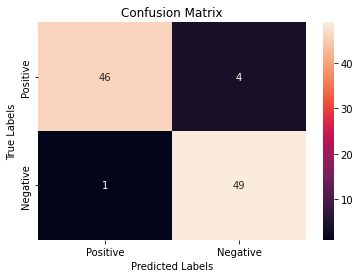

In [ ]:
model_evaluate(model, test_data)

### 3.6 Gridsearch Hyperparameter Tuning

In [ ]:
def GridSearchTrain(hidden_dim_grid, lstm_layer_grid, dropout_grid, embed_dim_grid, lr_grid, gamma_grid):
    #-------------------------------------------------------------------------
    #SGD
    torch.manual_seed(42)
    model_sgd = LSTM(hidden_layer=hidden_dim_grid, lstm_layer=lstm_layer_grid, embedding_layer=embed_dim_grid, p=dropout_grid).to(device)
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=lr_grid)
    scheduler_sgd = torch.optim.lr_scheduler.StepLR(optimizer_sgd, step_size = 5, gamma = gamma_grid)

    valid_loss_sgd, train_loss_sgd = model_run_train(model_train=model_sgd, optimizer_train=optimizer_sgd, scheduler=scheduler_sgd, mode_gridsearch=True)

    f1_score_sgd, precision_sgd, recall_sgd = model_evaluate(model_sgd, test_data, mode_gridsearch=True)
    
    #-------------------------------------------------------------------------
    #Adam
    torch.manual_seed(42)
    model_adam = LSTM(hidden_layer=hidden_dim_grid, lstm_layer=lstm_layer_grid, embedding_layer=embed_dim_grid, p=dropout_grid).to(device)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=lr_grid)
    scheduler_adam = torch.optim.lr_scheduler.StepLR(optimizer_adam, step_size = 5, gamma = gamma_grid)

    valid_loss_adam, train_loss_adam = model_run_train(model_train=model_adam, optimizer_train=optimizer_adam, scheduler=scheduler_adam, mode_gridsearch=True)

    f1_score_adam, precision_adam, recall_adam = model_evaluate(model_adam, test_data, mode_gridsearch=True)

    #-------------------------------------------------------------------------
    best_param = [hidden_dim_grid, lstm_layer_grid, dropout_grid, embed_dim_grid, lr_grid, gamma_grid]

    if f1_score_adam > f1_score_sgd:
        best_param.append('Adam')
        return f1_score_adam, precision_adam, recall_adam, valid_loss_adam, train_loss_adam, best_param
    elif f1_score_adam < f1_score_sgd:
        best_param.append('SGD')
        return f1_score_sgd, precision_sgd, recall_sgd, valid_loss_sgd, train_loss_sgd, best_param
    elif f1_score_adam == f1_score_sgd:
        if valid_loss_adam < valid_loss_sgd:
            best_param.append('Adam')
            return f1_score_adam, precision_adam, recall_adam, valid_loss_adam, train_loss_adam, best_param
        else:
            best_param.append('SGD')
            return f1_score_sgd, precision_sgd, recall_sgd, valid_loss_sgd, train_loss_sgd, best_param


In [ ]:
%%time
embedding_dim_param_list = [100, 200]
hidden_dim_param_list = [128, 256]
lstm_layer_param_list = [2, 3]
dropout_param_list = [0.5, 0.6, 0.7]
lr_param_list = [0.001, 0.005, 0.01]
gamma_param_list = [0.5, 0.75, 1]


# variabel f1 score terbaik
temp_best_score = 0
temp_best_val_loss = 999
temp_best_param = []

# iteration counter
iter_num = 0
max_iter = len(embedding_dim_param_list) * len(hidden_dim_param_list) * len(lstm_layer_param_list) * len(dropout_param_list) * len(lr_param_list) * len(gamma_param_list)

# membuat dokumentasi csv
csvFile = open('Result_Gridsearch_model.csv', 'a', encoding = 'utf-8') #creates a file in which you want to store the data.
csvWriter = csv.writer(csvFile)
csvWriter.writerow(['Hidden Layer', 'LSTM Layer', 'Dropout', 'Embedding Layer', 'Learning Rate', 'Gamma', 'Optimizer', 'Train Loss', 'Val Loss', 'Precision', 'Recall', 'F1 Score']) 


for embedding_dim_temp in embedding_dim_param_list:
    for hidden_dim_temp in hidden_dim_param_list:
        for lstm_layer_temp in lstm_layer_param_list:
            for dropout_temp in dropout_param_list:
              for lr_temp in lr_param_list:
                for gamma_temp in gamma_param_list:
                  score, precision, recall, val_loss, train_loss, params = GridSearchTrain(hidden_dim_temp, lstm_layer_temp, dropout_temp, embedding_dim_temp, lr_temp, gamma_temp)
                    
                  # Menambahkan hasil ke csv
                  csvWriter.writerow([params[0], params[1], params[2], params[3], params[4], params[5], params[6], train_loss, val_loss, precision, recall, score]) 

                  iter_num += 1
                  print(f'iteration done: {iter_num}/{max_iter}')

                  if score > temp_best_score:
                      temp_best_score = score
                      temp_best_val_loss = val_loss
                      temp_best_param = params
                  elif score == temp_best_score:
                      if val_loss < temp_best_val_loss:
                          temp_best_score = score
                          temp_best_val_loss = val_loss
                          temp_best_param = params

print('----------------------------------')
print('Best Model: ')
print('f1-score: ', temp_best_score)
print('val loss: ', temp_best_val_loss)
print('params: ', temp_best_param)

csvFile.close()

KeyboardInterrupt: ignored

In [ ]:
df_result = pd.read_csv("Result_Gridsearch_model.csv")
df_result.to_csv("/content/drive/MyDrive/Data Skripsi/Result_Gridsearch_model_cobacoba1.csv")